# Computing log probabilities with Diffusion Models

Here, we use the `log_prob` functionality of the diffusion model. For testing, we (1) use a simple Gaussian where we can analytically compute the marginal distributions for and (2) use a lollipop distribution and train a diffusion model on top of that.

In [1]:
import torch
import matplotlib.pyplot as plt
from notebook_setup import device
import numpy as np
# change device to whatever you want to use
device = torch.device('cuda:0')
from data.distributions import Lollipop
%load_ext autoreload
%autoreload 2

torch.manual_seed(0)

## Analytical check

Here we import a simple Gaussian and check if the log probabilities are computed correctly.

In [2]:
%autoreload 2
from models.diffusions.sdes.utils import VpSdeGaussianAnalytical
from models.diffusions.sdes import VpSde

mean = torch.tensor([2, 2], device=device)
cov = torch.tensor([[0.1, 0.3], [0.3, 1.6]], device=device)

score_net = VpSdeGaussianAnalytical(mean, cov)
score_net = score_net.to(device)
sde = VpSde(score_net)

/home/hamid/miniconda3/envs/mem/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/16 [00:00<?, ?it/s]/home/hamid/miniconda3/envs/mem/lib/python3.11/site-packages/torch/random.py:151: UserWarning: CUDA reports that you have 8 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of CUDAs. If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using. For example, if you are using CPU only, set device.upper()_VISIBLE_DEVICES= or devices=[]; if you are using device 0 only, set CUDA_VISIBLE_DEVICES=

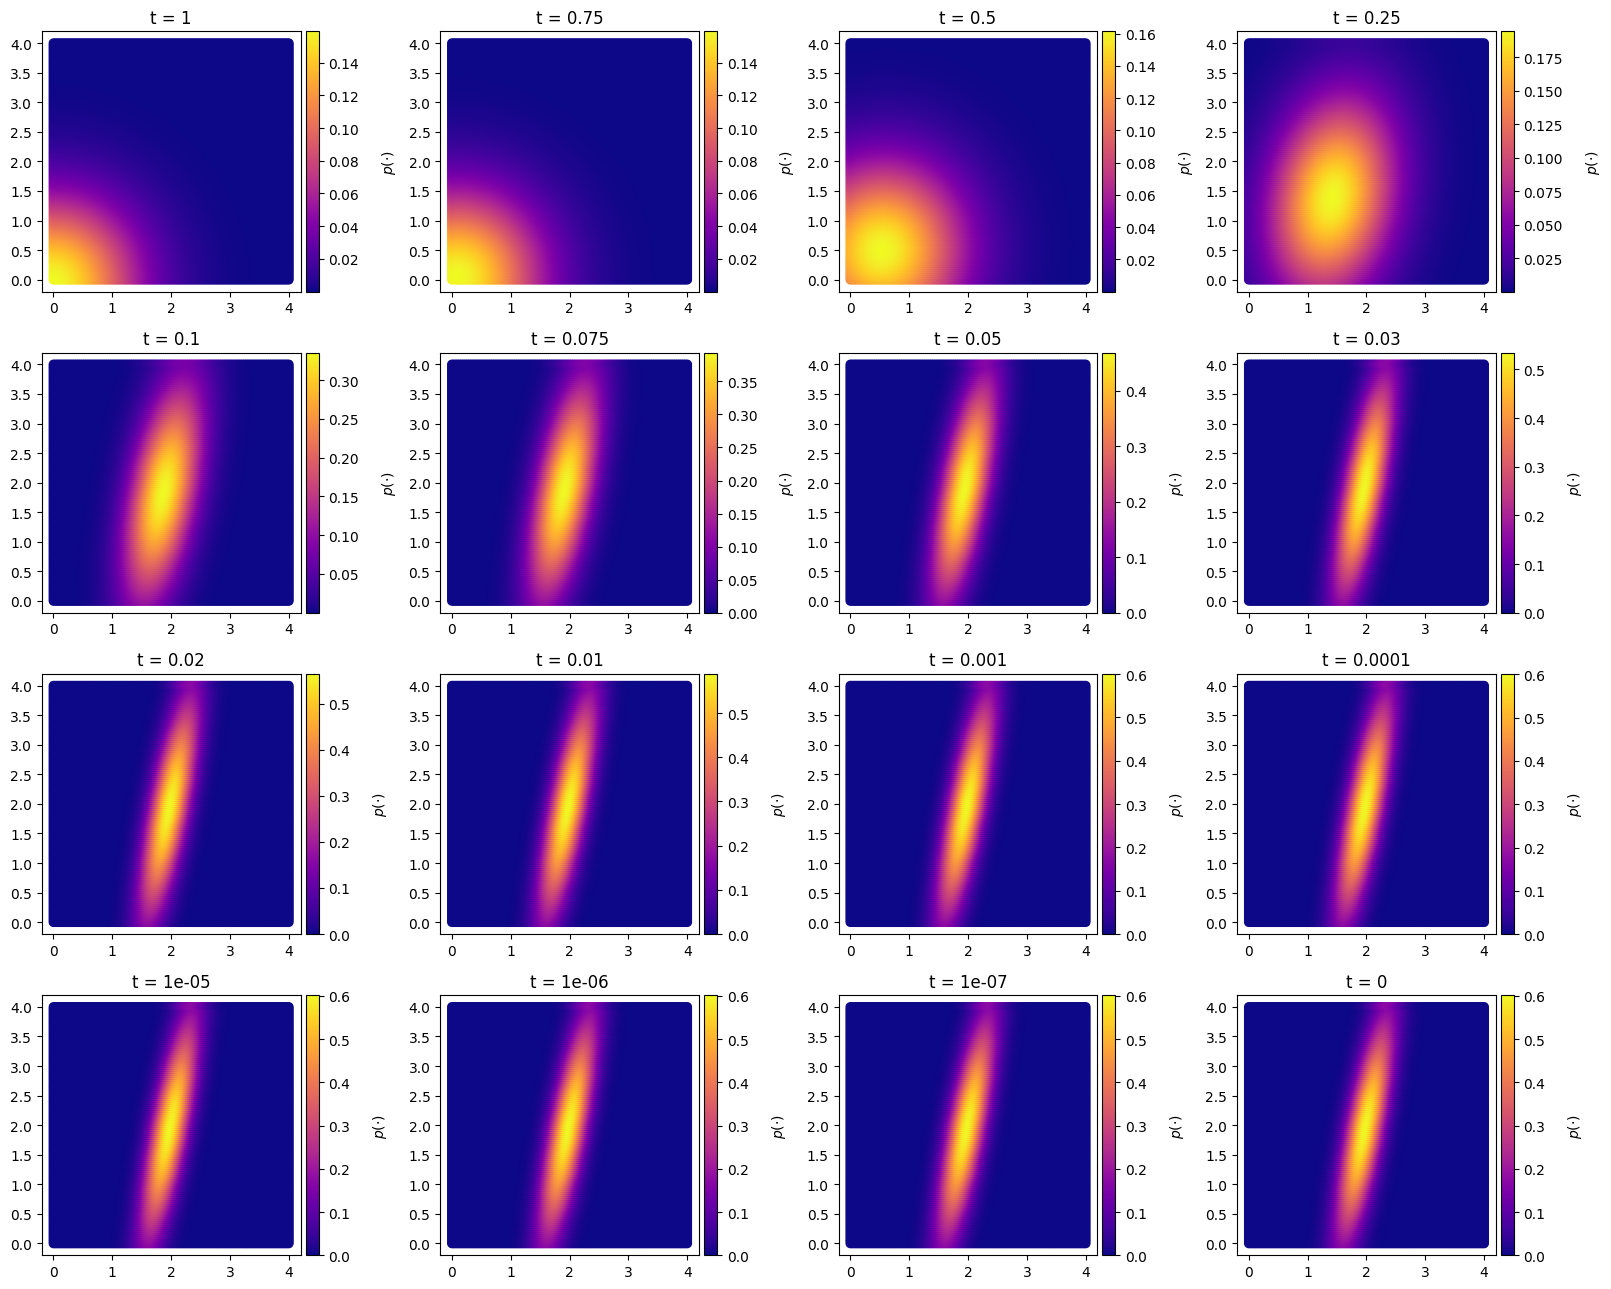

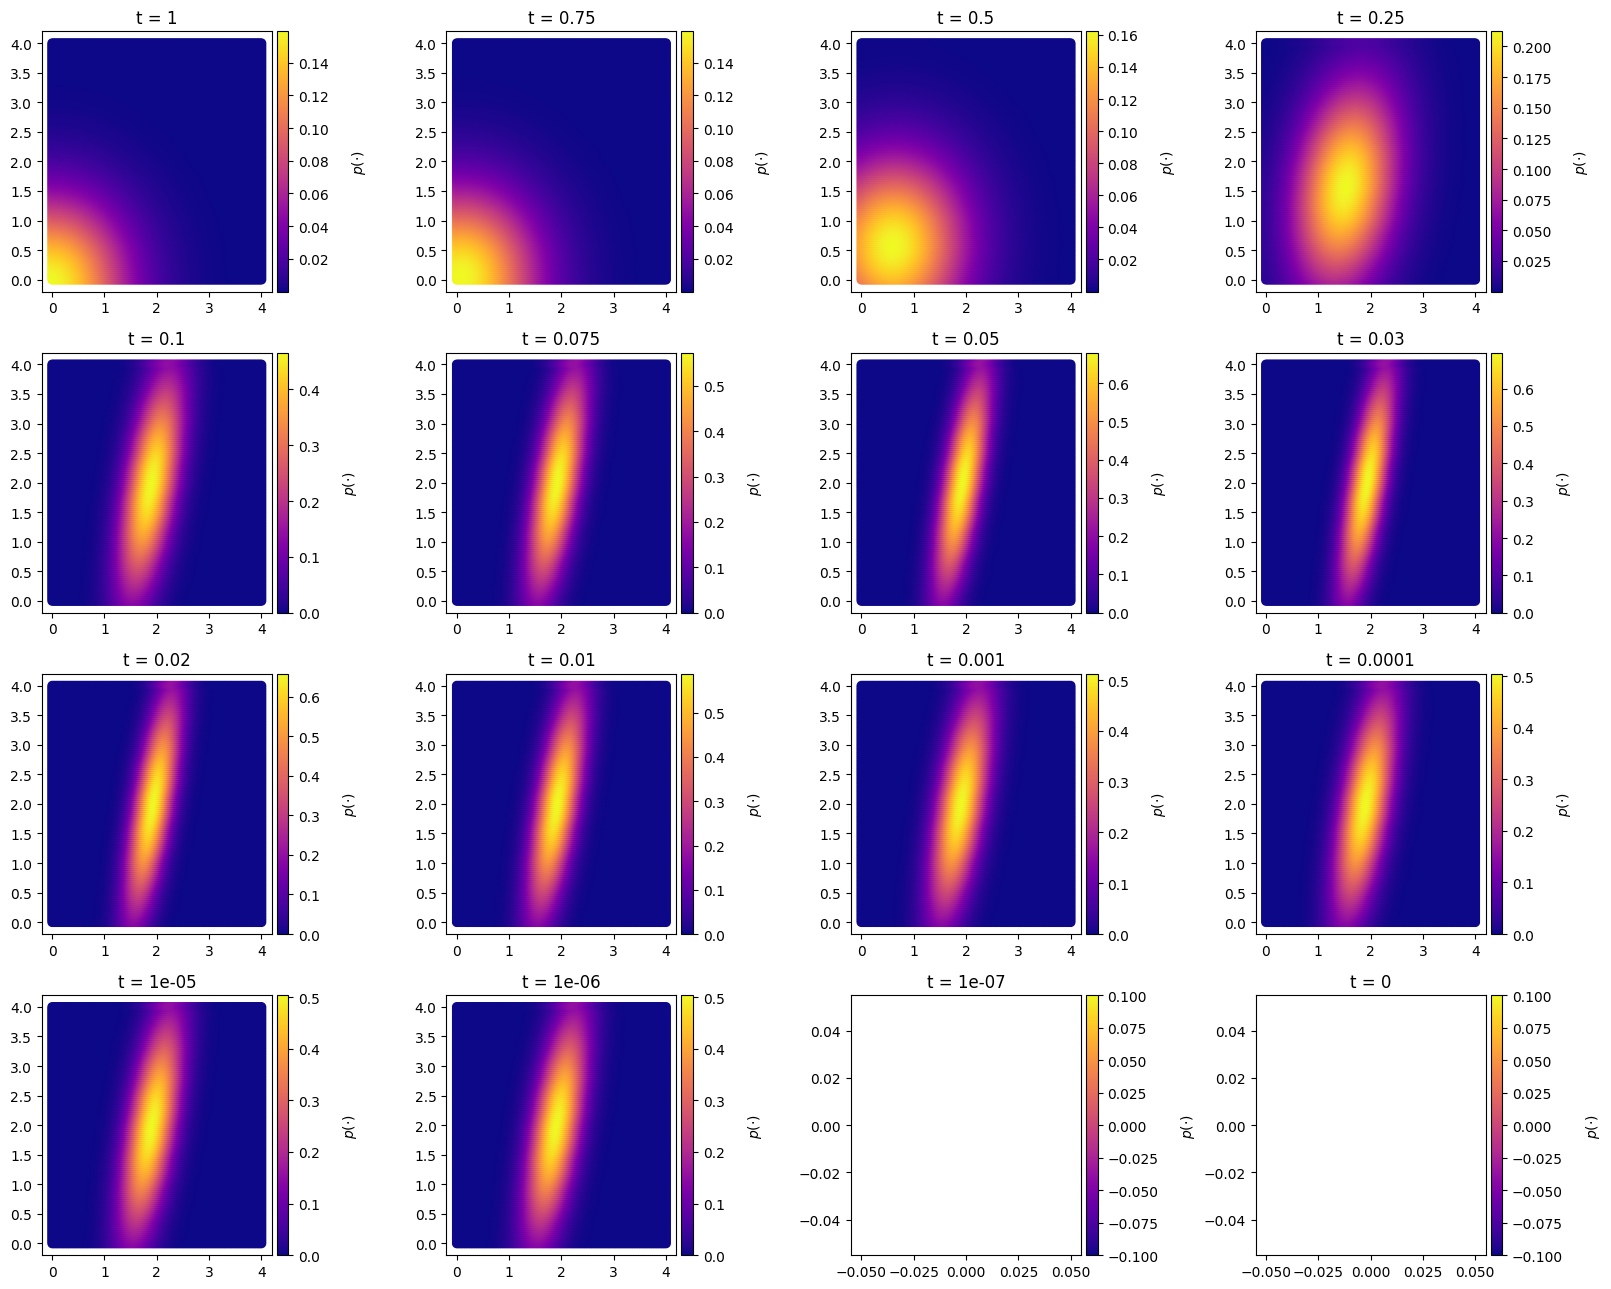

In [3]:
%autoreload 2
from visualization.notebook_utils import plot_log_prob_on_a_grid

# Create an N by 2 dataset of points on a grid between 0 and 4
N = 123
x = np.linspace(0, 4, N)
y = np.linspace(0, 4, N)
X, Y = np.meshgrid(x, y)
data = np.vstack([X.ravel(), Y.ravel()]).T
data = torch.tensor(data, dtype=torch.float32).to(device)

timesteps = (
    1,
    0.75,
    0.5,
    0.25,
    1e-1,
    7.5e-2,
    5e-2,
    3e-2,
    2e-2,
    1e-2,
    1e-3,
    1e-4,
    1e-5,
    1e-6,
    1e-7,
    0,
)

def log_prob_fn(x, t):
    t_repeated = torch.tensor(t, device=device)
    t_repeated = t_repeated.repeat(x.shape[0])
    return score_net.log_marginal_distribution(x, t_repeated)


plot_log_prob_on_a_grid(
    log_prob_fn=log_prob_fn,
    data=data,
    argument_name='t',
    argument_values=timesteps,
)
plot_log_prob_on_a_grid(
    sde=sde,
    data=data,
    argument_name='t',
    argument_values=timesteps,
    steps=10,
)

**Expected Result**: The two plots should be almost identical! One is obtained using the closed form and the other is obtained using the Euler Murayama technique.

## Lollipop Training

/home/hamid/miniconda3/envs/mem/lib/python3.11/site-packages/torch/random.py:151: UserWarning: CUDA reports that you have 8 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of CUDAs. If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using. For example, if you are using CPU only, set device.upper()_VISIBLE_DEVICES= or devices=[]; if you are using device 0 only, set CUDA_VISIBLE_DEVICES=0 or devices=[0].  To initialize all devices and suppress this warning, set the 'devices' keyword argument to `range(torch.cuda.device_count())`.
  warnings.warn(message)


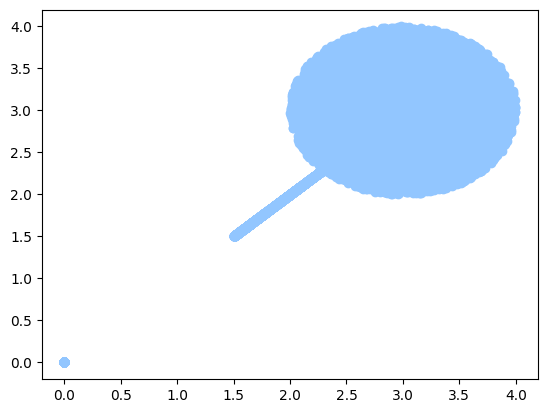

In [2]:

data = Lollipop().sample((10000, 2))
plt.scatter(*data.T)
plt.show()

Simialr to the [setup notebook](circle_experiment.ipynb), we train a diffusion model to fit the Lollipop distribution.

In [3]:

%autoreload 2
from data.datasets.generated import LIDSyntheticDataset
from data.distributions import Lollipop

from models.diffusions.sdes import VpSde
from models.diffusions.networks import MLPUnet
from models.training import LightweightTrainer
from models.diffusions.training import LightningDiffusion
from functools import partial
from torch import optim

dset = LIDSyntheticDataset(
    size=100000,
    distribution=Lollipop(),
    seed=42,
)

score_net = MLPUnet(2, hidden_sizes=(1024, 1024, 512, 512, 256, 128), time_embedding_dim=128).to(device)

sde = VpSde(score_net=score_net).to(device)

model = LightningDiffusion(
    sde=sde,
    optim_partial=partial(optim.Adam, lr=1e-5),
)
trainer = LightweightTrainer(
    max_epochs=100,
    device=device,
)
trainer.fit(
    model=model,
    train_dataloader=torch.utils.data.DataLoader(dset.x.to(device), batch_size=128),
    ckpt_path='outputs/notebooks/lollipop',
)
# The expected loss: < 0.4

/home/hamid/miniconda3/envs/mem/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Training epochs [Batch 782/782]: 100%|██████████| 100/100 [00:05<00:00,  5.28s/it, loss=0.383]


### Computing log probabilities

Here, we plot the log probabilities obtained from the model for different marginals with the default hyperparameter setting for log probs.

100%|██████████| 16/16 [03:48<00:00, 14.30s/it]


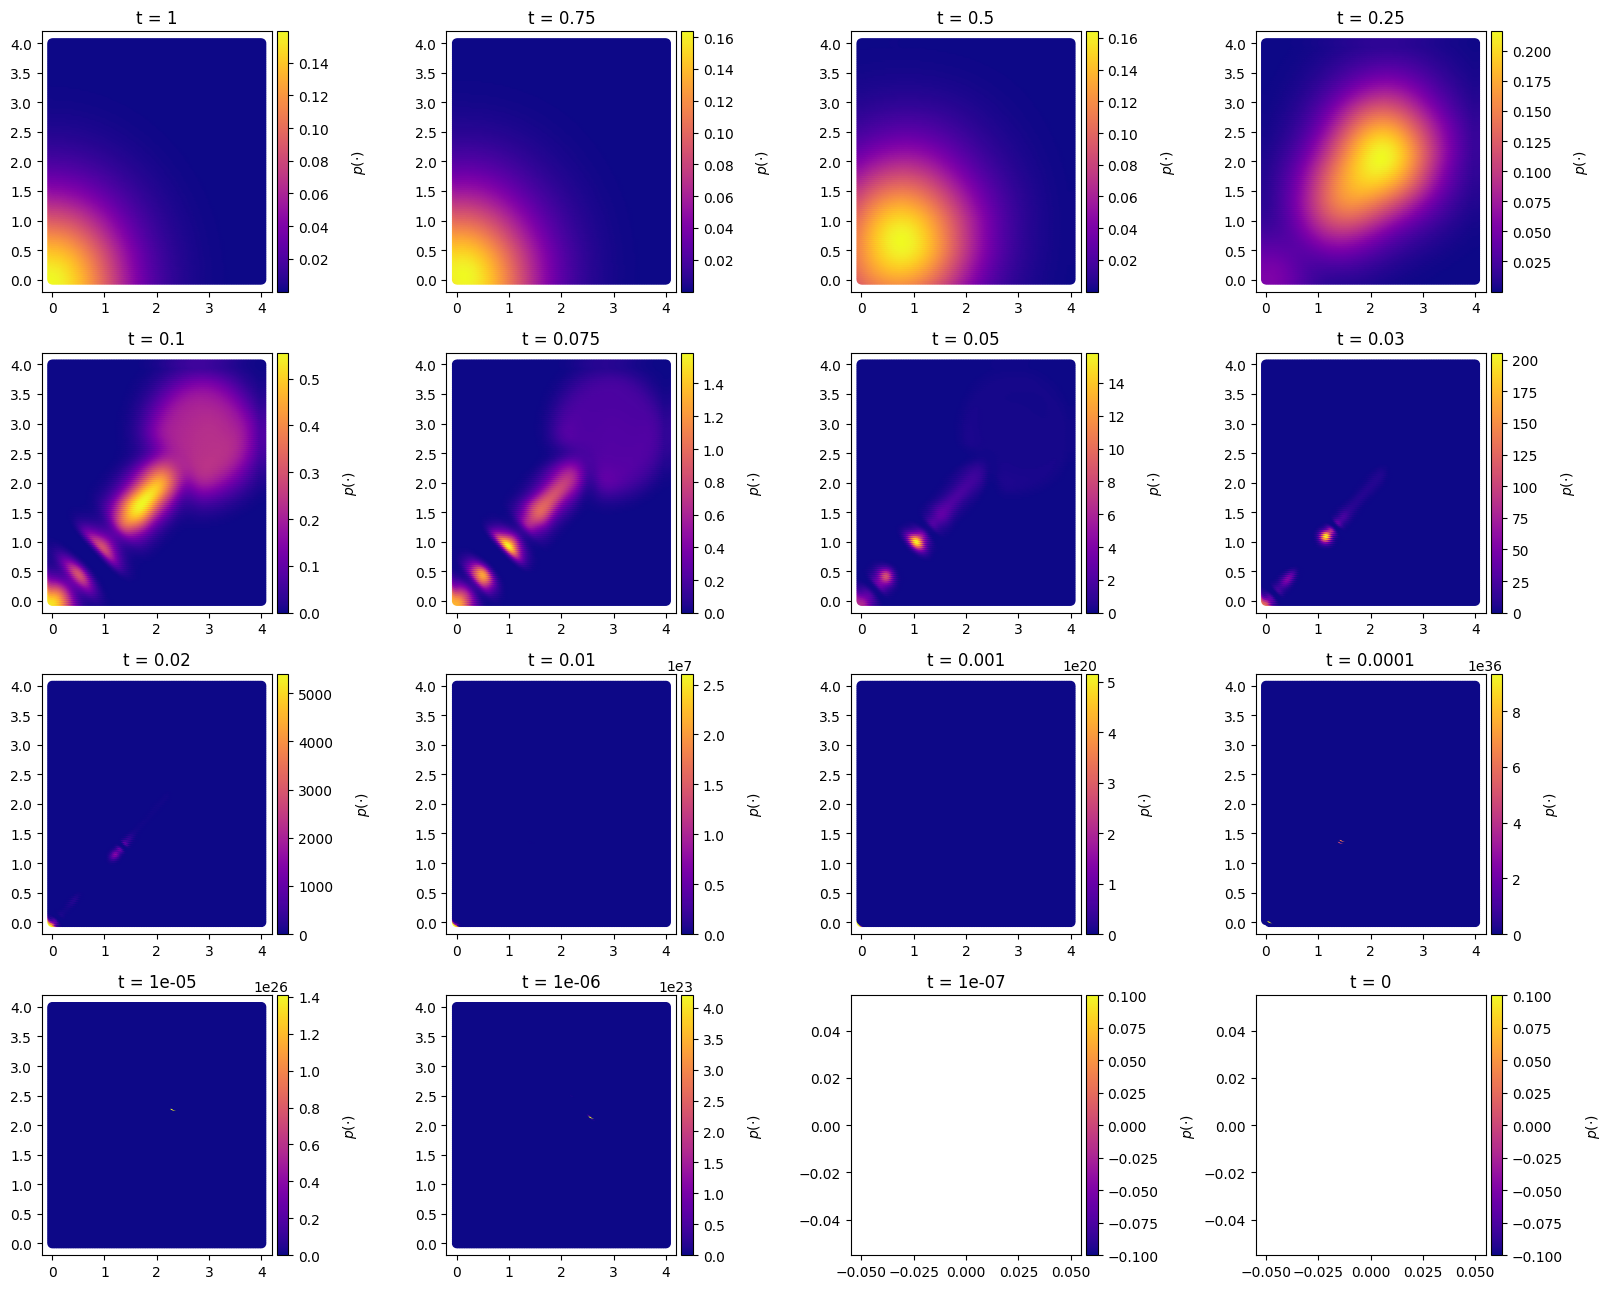

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from visualization.notebook_utils import plot_log_prob_on_a_grid

# Create an N by 2 dataset of points on a grid between 0 and 4
N = 123
x = np.linspace(0, 4, N)
y = np.linspace(0, 4, N)
X, Y = np.meshgrid(x, y)
data = np.vstack([X.ravel(), Y.ravel()]).T
data = torch.tensor(data, dtype=torch.float32).to(device)
timesteps = (
    1,
    0.75,
    0.5,
    0.25,
    1e-1,
    7.5e-2,
    5e-2,
    3e-2,
    2e-2,
    1e-2,
    1e-3,
    1e-4,
    1e-5,
    1e-6,
    1e-7,
    0,
)
plot_log_prob_on_a_grid(
    data=data,
    sde=sde,
    argument_name="t",
    argument_values=timesteps,
    steps=10,
)

**Expected Results**: At some timestep, the probability density heatmap should represent the lollipop distribution.

The following uses the trace estimation methods instead of exact computation.

100%|██████████| 16/16 [1:48:19<00:00, 406.23s/it]


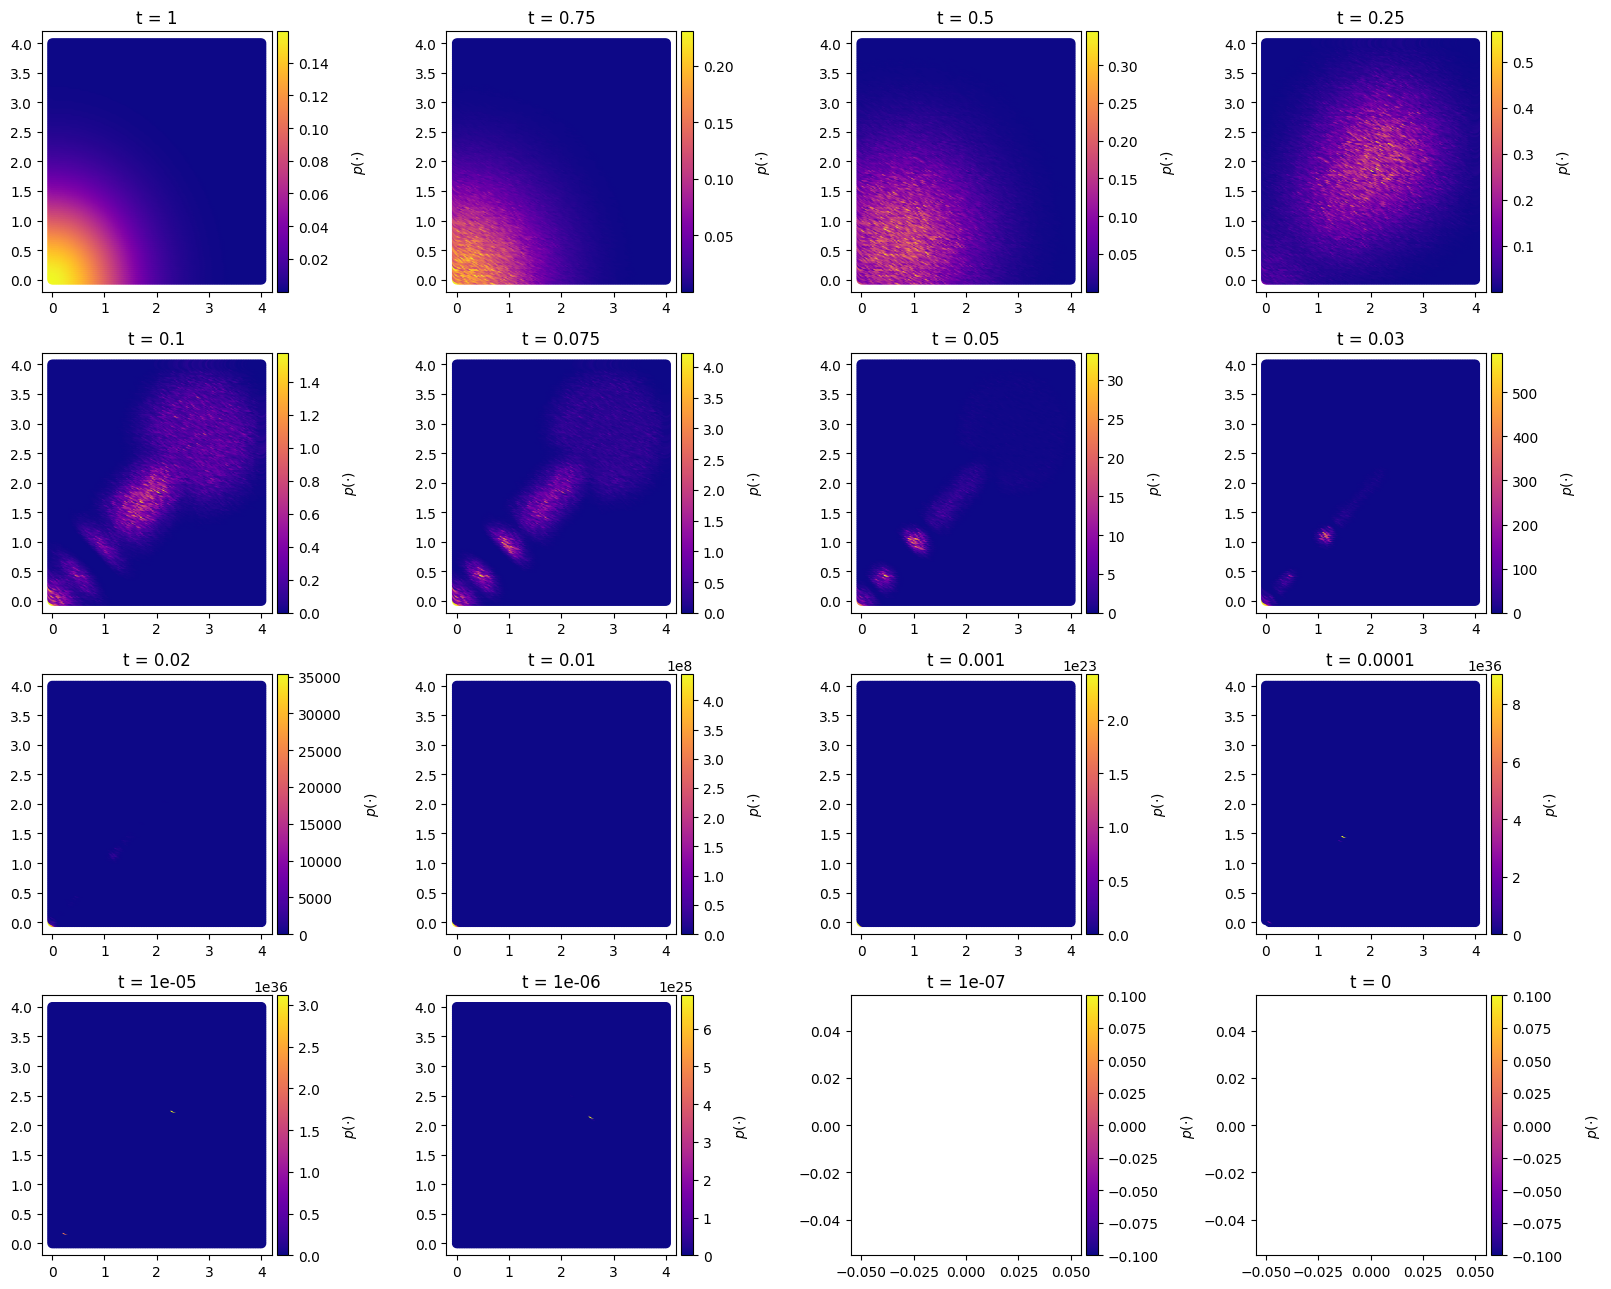

In [4]:
from visualization.notebook_utils import plot_log_prob_on_a_grid
# Create an N by 2 dataset of points on a grid between 0 and 4
N = 123
x = np.linspace(0, 4, N)
y = np.linspace(0, 4, N)
X, Y = np.meshgrid(x, y)
data = np.vstack([X.ravel(), Y.ravel()]).T
data = torch.tensor(data, dtype=torch.float32).to(device)
timesteps = (
    1,
    0.75,
    0.5,
    0.25,
    1e-1,
    7.5e-2,
    5e-2,
    3e-2,
    2e-2,
    1e-2,
    1e-3,
    1e-4,
    1e-5,
    1e-6,
    1e-7,
    0,
)

plot_log_prob_on_a_grid(
    data=data.to(device),
    sde=sde.to(device),
    argument_name="t",
    argument_values=timesteps,
    steps=10,
    laplacian_kwargs=dict(
        method="hutchinson_gaussian",
        hutchinson_sample_count=1024, # this value should be rediculously high for good results!
        chunk_size=4096 * 4, # set larger for faster computation but more memory usage
        seed=42,
        verbose=False,
    )
)

**Expected Results**: At some timestep, the probability density heatmap should represent the lollipop distribution. It might not be as good as the first plot, but it should still be roughly comparable.